In [1]:
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
from utils import flat_list
import warnings
from load_data import massage_data

In [2]:
index2measure=["CH1: Microphone",
"CH 2: Fingergrip",
"CH 3: Axial Pressure of ink Refill",
"CH 4: Tilt and Acceleration in X direction",
"CH 5: Tilt and Acceleration in Y direction",
"CH 6: Tilt and Acceleration Z direction"]

In [3]:
def load_NewHandPD(group,data):
    replace="P" if group == "Patients" else "H"
    data_path=join("..","NewHandPD",group,"Signal","Signal")
    task_path=listdir(data_path)
    task_path.sort()
    counter=0
    for task in task_path:#first file is `.DS_Store`
        if task[0:5]=="sigSp":
            path=join(data_path,task)
            #id_=int(task[-6:-4].replace(replace,""))-1#-1 to index
            data.append(np.loadtxt(path, dtype=float, skiprows=17,delimiter="\t"))
            counter+=1
    print(counter)
    if group == "Patients":
        assert counter/4==31
    else:
        assert counter/4==35

In [4]:

data=[]
warnings.warn("You should first load Patients then Healthy, else your targets will be wrong !")
load_NewHandPD("Patients",data)
load_NewHandPD("Healthy",data)
targets=[1 for _ in range(31*4)]+[0 for _ in range(35*4)]#*4 because each subject did 4 spirals
print(len(data))

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: You should first load Patients then Healthy, else your targets will be wrong !
  This is separate from the ipykernel package so we can avoid doing imports until


124
140
264


Thanks to this loading the data is organized as [Patients, Control]  
Where each index is a spiral. Each subject drew 4 spirals and the data is grouped by subject, e.g. index 0-3 represent the 4 spirals drawn by subject 0.  

In [5]:
lengths=[len(i) for i in data]

Therefore when we split the data into 31+35 = 66 equal part, each index represents one subject.  
Since we first loaded the patients, `subjects_lengths[0:31]` represents patients, while `subjects_lengths[31:66]` represents controls

In [30]:
subjects_lengths=np.split(np.asarray(lengths),31+35)

In [33]:
print("first subject drew 4 spirals of length :",subjects_lengths[0],"respectively")

first subject drew 4 spirals of length : [36100 17100 20100 13100] respectively


We average over each subject to get the average length of each exam the subject took (restricted to the spiral exams)

In [34]:
subjects_lengths=np.mean(subjects_lengths,axis=1)

We can clearly see a gap after subject n°30, which is the last PD patient.

Text(0,0.5,'average length of the exam')

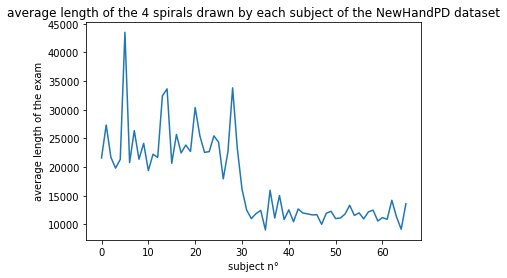

In [37]:
plt.plot(subjects_lengths)
plt.title("average length of the 4 spirals drawn by each subject of the NewHandPD dataset")
plt.xlabel("subject n°")
plt.ylabel("average length of the exam")

# Confusion Matrix
## when setting threshold at median(subjects_lengths)



In [24]:
median=np.median(subjects_lengths)

In [27]:
len([i for i in subjects_lengths[:31] if i >median])

31

In [28]:
len([i for i in subjects_lengths[31:] if i <=median])

33

 Predicted/Condition | Condition positive |	Condition negative 
--|--|--
Predicted positive| 31 | 0
Predicted negative| 2 | 33

Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
97 | 100 | 94 | 100 | 100




## when setting threshold at max(control_lengths)



In [23]:
max_control=np.max(subjects_lengths[31:])

In [25]:
len([i for i in subjects_lengths[:31] if i >max_control])

31

In [26]:
len([i for i in subjects_lengths[31:] if i <=max_control])

35

 Predicted/Condition | Condition positive |	Condition negative 
--|--|--
Predicted positive| 31 | 0
Predicted negative| 0 | 35

Accuracy|Se | Sp | PPV | NPV
--|--|--|--|--
100 | 100 | 100 | 100 | 100

# Exploration

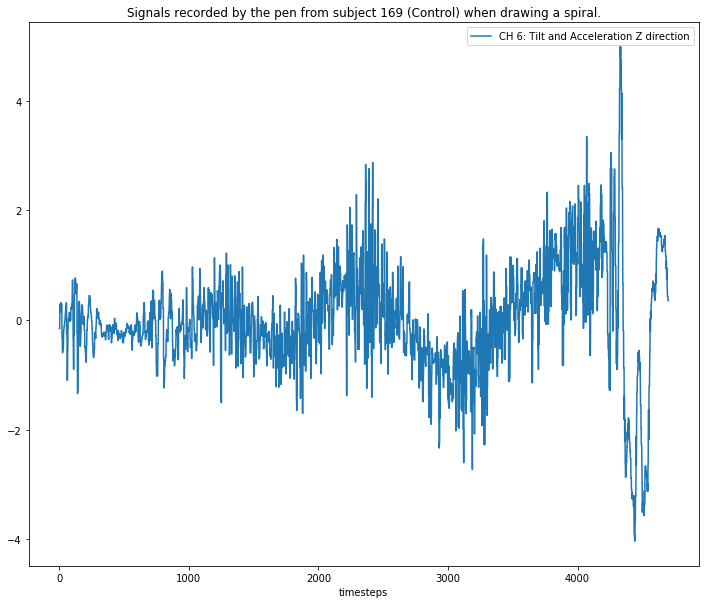

In [22]:
index=169#np.random.randint(0,len(data))
plt.figure(figsize=(12,10))
pd_control="PD" if targets[index] == 1 else "Control"
plt.title("Signals recorded by the pen from subject {} ({}) when drawing a spiral.".format(index,pd_control))
plt.xlabel("timesteps")
for i in [5]:
    plt.plot(data[index][:,i],label=index2measure[i])
    plt.legend()

Text(0.5,1,'Tilt and Acceleration in X VS Y direction')

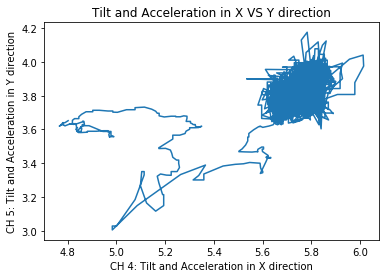

In [54]:
plt.plot(task[:,3],task[:,4])
plt.xlabel(index2measure[3])
plt.ylabel(index2measure[4])
plt.title("Tilt and Acceleration in X VS Y direction")